# **Deep learning entry task**
 <img src="https://www.tu-braunschweig.de/typo3conf/ext/tu_braunschweig/Resources/Public/Images/Logos/tu_braunschweig_logo.svg" align="right" width="200px"/>

[Institute of Geodesy and Photogrammetry](https://www.tu-braunschweig.de/en/igp),  
[The Technical University of Braunschweig  ](https://www.tu-braunschweig.de/en/)  
Instructors: [Dr. -Ing. Mehdi Maboudi](https://www.tu-braunschweig.de/en/igp/staff/mehdi-maboudi) and [Dr. Pedro Achanccaray](https://www.tu-braunschweig.de/en/igp/staff/pedro-diaz)
<br clear="left"/>

The purpose of this entry task is to measure your **knowledge of machine learning and artificial neural network concepts**. You should be familiar with these topics for **better understanding and comprehension** of the deep learning course.


For this reason, the entry task should be solved **without using any artificial intelligence tools** (ChatGPT, Copilot, among others). You can only use them to assist you in **debugging** your code.

# **1. Import all necessary packages**

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from typing import List 
from torch.utils.data import TensorDataset, DataLoader

In [2]:
print(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))

cuda:0


In [3]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# Define the classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')


# **2. Load the Fashion MNIST dataset for image classification**

- Load the Fashion MNIST dataset.
- Create three disjoint sets: train, validation and test (you can use any proportions for these sets).

In [5]:
train_data = torchvision.datasets.FashionMNIST('data', train=True, download=True,
                                   transform=transforms.Compose([
                                       transforms.ToTensor(),
                                   ]))
train_loader = DataLoader(train_data, batch_size=64, shuffle=False)

In [6]:
n_samples_seen = 0.
mean = 0
std = 0
for train_batch, train_target in train_loader:
    batch_size = train_batch.shape[0]
    train_batch = train_batch.view(batch_size, -1)
    this_mean = torch.mean(train_batch, dim=1)
    this_std = torch.sqrt(
        torch.mean((train_batch - this_mean[:, None]) ** 2, dim=1))
    mean += torch.sum(this_mean, dim=0)
    std += torch.sum(this_std, dim=0)
    n_samples_seen += batch_size

mean /= n_samples_seen
std /= n_samples_seen

In [7]:
mean

tensor(0.2860)

In [8]:
std

tensor(0.3202)

In [9]:
composer = transforms.Compose([transforms.ToTensor(),
                               transforms.RandomCrop(28,padding=1),
                               transforms.Normalize(mean=mean.view(1),
                                                            std=std.view(1))])

In [10]:
train_data = torchvision.datasets.FashionMNIST('data', train=True, download=True,
                                   transform=composer)

test_data = torchvision.datasets.FashionMNIST('data', train=False, download=True,
                                  transform=composer)



In [11]:
validation_ratio= 0.2

In [12]:
num_train = len(train_data)
indices = list(range(num_train))
split = int(np.floor(validation_ratio * num_train))

In [13]:
# Shuffle the indices
np.random.shuffle(indices)

In [14]:
train_idx, valid_idx = indices[split:], indices[:split]

In [15]:
# Define samplers for obtaining training and validation batches
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(valid_idx)


In [16]:
# Define data loaders for training, validation, and test sets
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, sampler=train_sampler, num_workers=2)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=64, sampler=valid_sampler, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False, num_workers=2)


In your own words, describe the purpose of each set:
- _train_:
- _validation_:
- _test_:

# **3. Create a Multi Layer Perceptron (MLP) for image classification**


Feel free to use any configuration (number of hidden layers, number of neurons per layer) and framework (Scikit learn, Keras, TensorFlow, PyTorch, etc.)

In [17]:
class ResidualBlock(torch.nn.Module):
    def __init__(self,channels):
        super(ResidualBlock,self).__init__()
        self.channels = channels
        
        self.conv1 = torch.nn.Conv2d(channels,channels,kernel_size=3,padding=1)
        self.conv2 = torch.nn.Conv2d(channels,channels,kernel_size=3,padding=1)
    
    def forward(self, x):
        y = F.relu(self.conv1(x))
        y = self.conv2(y)
        return F.relu(x+y)


In [18]:
class Net(torch.nn.Module):
    def __init__(self,input_size=1,hidden_size=16,hidden_size2=32,classes=10):
        super(Net,self).__init__()
        self.conv1 = torch.nn.Conv2d(input_size,hidden_size,kernel_size=5)
        self.conv2 = torch.nn.Conv2d(hidden_size,hidden_size2,kernel_size=5)
        self.mp = torch.nn.MaxPool2d(2)
        
        self.rblock1 = ResidualBlock(hidden_size)
        self.rblock2 = ResidualBlock(hidden_size2)
        
        self.fc = torch.nn.Linear(512,classes)
        
    def forward(self,x):
        in_size = x.size(0)
        x = self.mp(F.relu(self.conv1(x)))
        x = self.rblock1(x)
        x = self.mp(F.relu(self.conv2(x)))
        x = self.rblock2(x)
        x = x.view(in_size,-1)  # flatten
#         print(x.size(1))
        return self.fc(x)
model = Net()


In [19]:
net = Net().to(device)

In [20]:
net

Net(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (rblock1): ResidualBlock(
    (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (rblock2): ResidualBlock(
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

# **4. Train the model**

Train the model and perform a hyperparameter tuning to find the best learning rate from a set of learning rates (1D grid search).

In [21]:
criterion = nn.CrossEntropyLoss()

In [22]:
learning_rates = [0.001,0.01]
max_acc_div_error=[]


In [23]:
class EpochDate:
    def __init__(self,epoch:int,losses:List[float],accuracies:List[float]) -> None:
        self.epoch = epoch
        self.losses = losses
        self.accuracies = accuracies
    def __str__(self) -> str:
        return f" Epoco: {self.epoch}, Loss: {self.losses}, Acc: {self.accuracies}"


In [24]:
class PlotData:
    def __init__(self,lr,epochDate:List[EpochDate]) -> None:
        self.lr = lr
        self.epochDate = epochDate
    def __str__(self) -> str:
        return f" lr: {self.lr}, epochDate: {self.epochDate}"

    
    

In [25]:
plot_train_Datas = []
plot_vali_Datas = []
def train(lr):
    net = Net().to(device)
    epochs = 10
       # Lists to store loss and accuracy values
    train_losses = []
    train_accuracy = []
    train__epochDate = []

    valid_losses = []
    valid_accuracy = []
    valid__epochDate = []
    
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
    
    for epoch in range(epochs):
          # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0
        running_total = 0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

        
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

        runningloss = running_loss / running_total
        
        train_losses.append(runningloss)

        

        
        runningacc = 100 * running_correct / running_total
        train_accuracy.append(runningacc)
        running_loss = 0.0
        max_acc_div_error.append((lr, runningacc/runningloss))
        print('lr %f Epoch %d loss: %.3f acc:%.3f' % (lr ,epoch + 1,runningloss,runningacc))


        # evaluate on validation set
        valid_loss = 0.0
        valid_correct = 0
        valid_total = 0
        with torch.no_grad():
            for data in valid_loader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = net(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                valid_total += labels.size(0)
                valid_correct += (predicted == labels).sum().item()

        validerror = valid_loss / len(valid_loader)
        valid_losses.append(valid_loss / len(valid_loader))
        validacc = 100 * valid_correct / valid_total
        valid_accuracy.append(validacc)
        print('valid: lr %f Epoch %d loss: %.3f acc:%.3f' % (lr ,epoch + 1,validerror,validacc))
        
    valid__epochDate.append(EpochDate(epoch = epochs,losses = valid_losses,accuracies = valid_accuracy))
    train__epochDate.append(EpochDate(epoch = epochs,losses = train_losses,accuracies = train_accuracy))
    plot_train_Datas.append(PlotData(lr,epochDate = train__epochDate))
    plot_vali_Datas.append(PlotData(lr,epochDate = valid__epochDate))
    torch.save(net.state_dict(), f'{lr}_trained_parameters.pth')
    print('Finished Training')

    

In [26]:
from threading import Thread
threads = []
for lr in learning_rates:
    t = Thread(target=train, args=(lr,))
    threads.append(t)
    t.start()

In [27]:
for t in threads:
    t.join()

lr 0.001000 Epoch 1 loss: 0.014 acc:69.588
lr 0.010000 Epoch 1 loss: 0.009 acc:78.392
valid: lr 0.001000 Epoch 1 loss: 0.604 acc:77.375
valid: lr 0.010000 Epoch 1 loss: 0.414 acc:84.825
lr 0.010000 Epoch 2 loss: 0.006 acc:85.983
lr 0.001000 Epoch 2 loss: 0.009 acc:79.104
valid: lr 0.010000 Epoch 2 loss: 0.386 acc:86.267
valid: lr 0.001000 Epoch 2 loss: 0.536 acc:80.308
lr 0.010000 Epoch 3 loss: 0.005 acc:87.600
lr 0.001000 Epoch 3 loss: 0.008 acc:81.569
valid: lr 0.010000 Epoch 3 loss: 0.325 acc:88.242
valid: lr 0.001000 Epoch 3 loss: 0.471 acc:82.333
lr 0.010000 Epoch 4 loss: 0.005 acc:88.615
lr 0.001000 Epoch 4 loss: 0.007 acc:83.388
valid: lr 0.010000 Epoch 4 loss: 0.308 acc:89.025
valid: lr 0.001000 Epoch 4 loss: 0.447 acc:83.767
lr 0.010000 Epoch 5 loss: 0.005 acc:89.252
lr 0.001000 Epoch 5 loss: 0.007 acc:84.344
valid: lr 0.010000 Epoch 5 loss: 0.301 acc:89.575
valid: lr 0.001000 Epoch 5 loss: 0.411 acc:85.533
lr 0.010000 Epoch 6 loss: 0.004 acc:89.844
lr 0.001000 Epoch 6 loss: 0

In [28]:
best_lr = max(max_acc_div_error, key = lambda x: x[1])[0] # I try to divide accuracy by error rate, the maximum value of this result better reflects the goodness of the model.
print("Best learning rate:", best_lr)

Best learning rate: 0.01


# **5. Plots**

Plot the evolution of the Loss function and Accuracy values over the epochs (for train and validation sets) during training the best model.

- What can you infere from the training curves of the model? 
- Is there over- or underfitting?

range(1, 11)
range(1, 11)


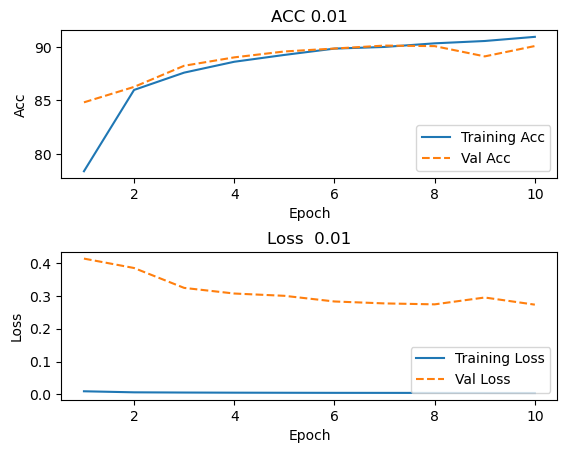

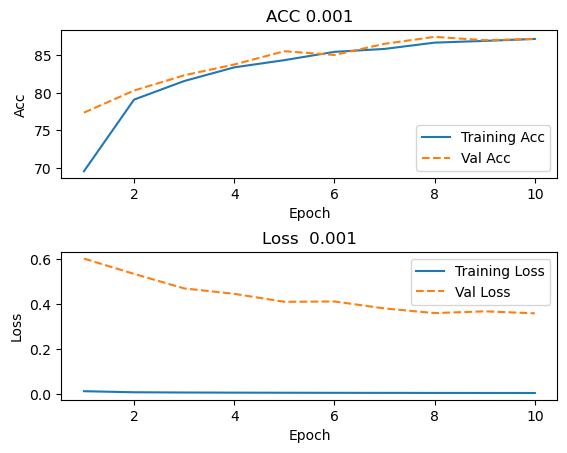

In [47]:
import matplotlib.pyplot as plt
# Plotting the loss and accuracy curves
#plot_train_Datas
i=0
for plotdata in plot_train_Datas:
    lr = plotdata.lr
    val_plotdatas=plot_vali_Datas[i].epochDate
    j = 0
    for item2 in plotdata.epochDate:
        val_epochData =val_plotdatas[j]
        #print(val_epochData)
        #print(item2)
        x = range(1,item2.epoch+1)
        y1 = item2.losses
        y2  =  item2.accuracies
        y3 = val_epochData.losses
        y4  =  val_epochData.accuracies
        #plt.figure(figsize=(10, 5))
        fig, axs = plt.subplots(2)

        axs[0].plot(x, y2, label='Training Acc') 
        axs[0].plot(x, y4, label='Val Acc',linestyle='--')  
        axs[0].set_title(f'ACC {lr}') 
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Acc')
        axs[0].legend()

        

        axs[1].plot(x, y1, label='Training Loss')
        axs[1].plot(x, y3, label='Val Loss',linestyle='--')
        axs[1].set_title(f'Loss  {lr}')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Loss')
        axs[1].legend()
        plt.subplots_adjust(hspace=0.5) 
        print(x)
        j = j + 1
    i = i + 1



<font color=#3366FF>Firstly, it can be inferred from the graph that when the learning rate is 0.001, the model has learned some content. Since the training and validation sets are similar, it is difficult to determine whether it is overfitting or underfitting. However, from the test dataset, there seems to be a certain degree of underfitting.</font>


# **6. Run inference**

Run inference in the test set and compute the metrics for testing.

In [30]:

net = Net().to(device)
path = f"./{best_lr}_trained_parameters.pth"
net.load_state_dict(torch.load(path))
def test(dataset):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataset:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# **7. Test samples**

Show some samples from the test set. Use the following layout: input image, reference class and predicted class.

In [31]:
acc = test(test_loader)

In [32]:
acc

89.53

# **8. Testing with new images**


Test the model with at least two images (from internet or take a photo with your phone or camera). 

Do not forget to convert the image to the Fashion MNIST format: grayscale, $28\times 28$, apply normalization, etc. 

Comment the results.

In [33]:
import cv2 

In [34]:
image_url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRq1XCYWZLfMDq7qFb2HeYhkQwuolzFg90hfXXJE_bbLg&s"

In [35]:
import requests
response = requests.get(image_url)

In [36]:
response

<Response [200]>

In [37]:
image_source = np.asarray(bytearray(response.content),dtype=np.uint8)

In [38]:
image_source

array([255, 216, 255, ...,  63, 255, 217], dtype=uint8)

In [39]:
image = cv2.imdecode(image_source,cv2.IMREAD_GRAYSCALE)

In [40]:
from IPython.display import display, Image

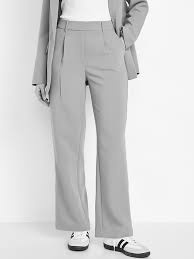

In [41]:
ret, buffer = cv2.imencode('.jpg', image)
image_jpg = buffer.tobytes()
display(Image(data=image_jpg))

In [42]:
input_tensor = composer(image)

In [43]:
output = net(input_tensor.to(device))

In [44]:
_, predicted_class = torch.max(output, 1)

In [45]:
predicted_class = predicted_class.item()

In [46]:
classes[predicted_class]

'Bag'

# **9. How could we improve the trained model?**

Share your ideas and comments to further improve the results.

<font color=#3366FF>
1. Firstly, GPU to use. Adjusting batch size and adding batch normalization layers can enhance generalization capability and optimize transformers.<br>
2. Increase the model depth, for example, by using VGG, ResNet, or even VIT networks.<br>
3. Modify activation functions.for example, by using Tanh, Leaky ReLU, Swish.<br>
4. Modify the loss function and optimizer. for example, by using Adam,Adagrad.

</font>